# RG374 LegendPlex analysis IFNAR fl LysMcre CpG

In [35]:
options(warn=-1)

In [36]:
library_load <- suppressMessages(
    
    suppressWarnings(
        
        list(
                         
            # Data 
            library(tidyverse), 
            library(data.table), 
            library(reactable), 

            # Plotting 
            library(ComplexHeatmap), 
            library(patchwork), 
            library(cowplot), 
            library(ggrepel), 
            
            # Statistics
            library(emmeans)

        )
    )
)

In [37]:
random_seed <- 42
set.seed(random_seed)

In [38]:
# Set working directory to project root
setwd("/research/peer/fdeckert/FD20200109SPLENO")

In [39]:
# Plotting Theme
source("plotting_global.R")
ggplot2::theme_set(theme_global_set(size_select=1)) # From project global source()

# Plasma 

## Log2FC heatmap 

In [50]:
mat <- read.csv("data/RG374_ifnar_fl_lysmcre_cpg/legendplex/plasma/RG374_ifnar_fl_lysmcre_cpg_plasma_legendplex_data_2024_08_23.csv") %>% 
    dplyr::select(-Mutation.1, -Grad.1, -Mutation.2, -sample) %>% 
    dplyr::rename(genotype=Grad.2, time_point=well) %>% 
    rename_with(~gsub(".", "-", ., fixed=TRUE)) %>% 
    reshape2::melt(., id.vars=c("genotype", "time_point"), variable="cytokine", value.name=c("concentration")) %>% 
    dplyr::group_by(genotype, time_point, cytokine) %>% dplyr::summarise(mean=mean(concentration)) %>% dplyr::ungroup() %>% 
    reshape2::dcast(., time_point + cytokine ~ genotype, value.var="mean") %>% 
    dplyr::mutate(log2fc= log2(`+/+`/`cre/+`)) %>% 
    dplyr::select(time_point, cytokine, log2fc) %>% 
    reshape2::dcast(., time_point ~ cytokine, value.var="log2fc") %>% 
    dplyr::mutate(time_point=ifelse(time_point=="baseline", "D0", gsub("day", "D", time_point))) %>% 
    tibble::column_to_rownames("time_point") %>% as.matrix()

`summarise()` has grouped output by 'genotype', 'time_point'. You can override
using the `.groups` argument.


In [89]:
# Color function - DEG count
color_ramp_mat <- c(color$sample_group["IFNAR_fl_CpG_D1"], "#ffffff", color$sample_group["IFNAR_fl_LysM_cre_CpG_D1"])
breaks_mat <- seq(-round(max(abs(mat))), round(max(abs(mat))), length.out=length(color_ramp_mat))
color_function_mat <- circlize::colorRamp2(breaks_mat, color_ramp_mat) 

In [90]:
hm <- ComplexHeatmap::Heatmap(
    
    matrix=mat,

    col=color_function_mat, 
    na_col="white", 

    width=unit(10*ncol(mat), "mm"), 
    height=unit(10*nrow(mat), "mm"), 

    row_title=NULL, 
    row_title_gp=gpar(fontsize=16, fontface="bold"), 

    column_title="Cytokine log2FC pg/ml (Plasma)", 
    column_title_gp=gpar(fontsize=16, fontface="bold"), 

    row_names_gp=gpar(fontsize=16, fontface="italic"), 
    column_names_gp=gpar(fontsize=16, fontface="plain"), 

    cluster_rows=FALSE, 
    show_row_dend=FALSE,
    row_gap=unit(2, "mm"), 
    show_row_names=TRUE, 
    row_names_side="left", 

    cluster_columns=FALSE, 
    cluster_column_slices=FALSE, 
    show_column_dend=FALSE, 
    column_split=NULL, 
    column_gap=unit(1, "mm"), 
    show_column_names=TRUE, 

    top_annotation=NULL, 
    left_annotation=NULL, 

    rect_gp=gpar(col=NA, lwd=0, alpha=1), 

    heatmap_legend_param=list(title="log2FC", title_gp=gpar(fontsize=16, fontface="plain"), labels_gp=gpar(fontsize=16), grid_width=unit(2.5, "mm"), legend_width=unit(2.5, "mm"), grid_height=unit(10, "mm"), legend_height=unit(10, "mm"), at=breaks_mat), 

    border=TRUE, 
    border_gp=gpar(col="black", lwd=unit(0.2, "mm")), 

    use_raster=FALSE, raster_by_magick=FALSE


)

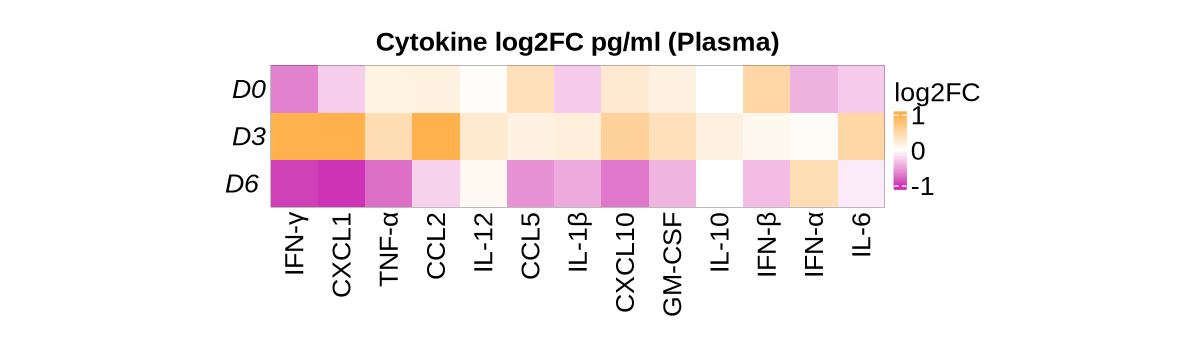

In [91]:
options(repr.plot.width=10, repr.plot.height=3)

hm

## Bar plot 

In [115]:
color$genotype <- c("+/+"="#FFFFFF", "cre/+"="#998989")

In [116]:
mat <- read.csv("data/RG374_ifnar_fl_lysmcre_cpg/legendplex/plasma/RG374_ifnar_fl_lysmcre_cpg_plasma_legendplex_data_2024_08_23.csv") %>% 
    dplyr::select(-Mutation.1, -Grad.1, -Mutation.2, -sample) %>% 
    dplyr::rename(genotype=Grad.2, time_point=well) %>% 
    rename_with(~gsub(".", "-", ., fixed=TRUE)) %>% 
    reshape2::melt(., id.vars=c("genotype", "time_point"), variable="cytokine", value.name=c("concentration")) %>% 
    dplyr::mutate(time_point=ifelse(time_point=="baseline", "D0", gsub("day", "D", time_point))) %>% 
    dplyr::mutate(genotype=factor(genotype, levels=c("+/+", "cre/+")))

In [117]:
bar_plot <- function(mat) {
    
    ggplot(mat, aes(x=time_point, y=concentration, color=genotype, fill=genotype)) + 
    
        geom_bar(stat="summary", position=position_dodge2(), width=0.75, fun=mean, color="black") + 
        geom_jitter(position=position_jitterdodge(dodge.width=0.75), shape=21, stroke=1.0, size=3, show.legend=FALSE, color="black") + 
        xlab("") + ylab("pg/ml") + ggtitle(mat$cytokine[1]) + 
        scale_color_manual(values=color$genotype) + 
        scale_fill_manual(values=color$genotype) 
    
}

bar_plot_1 <- lapply(split(mat, f=mat$cytokine), bar_plot)

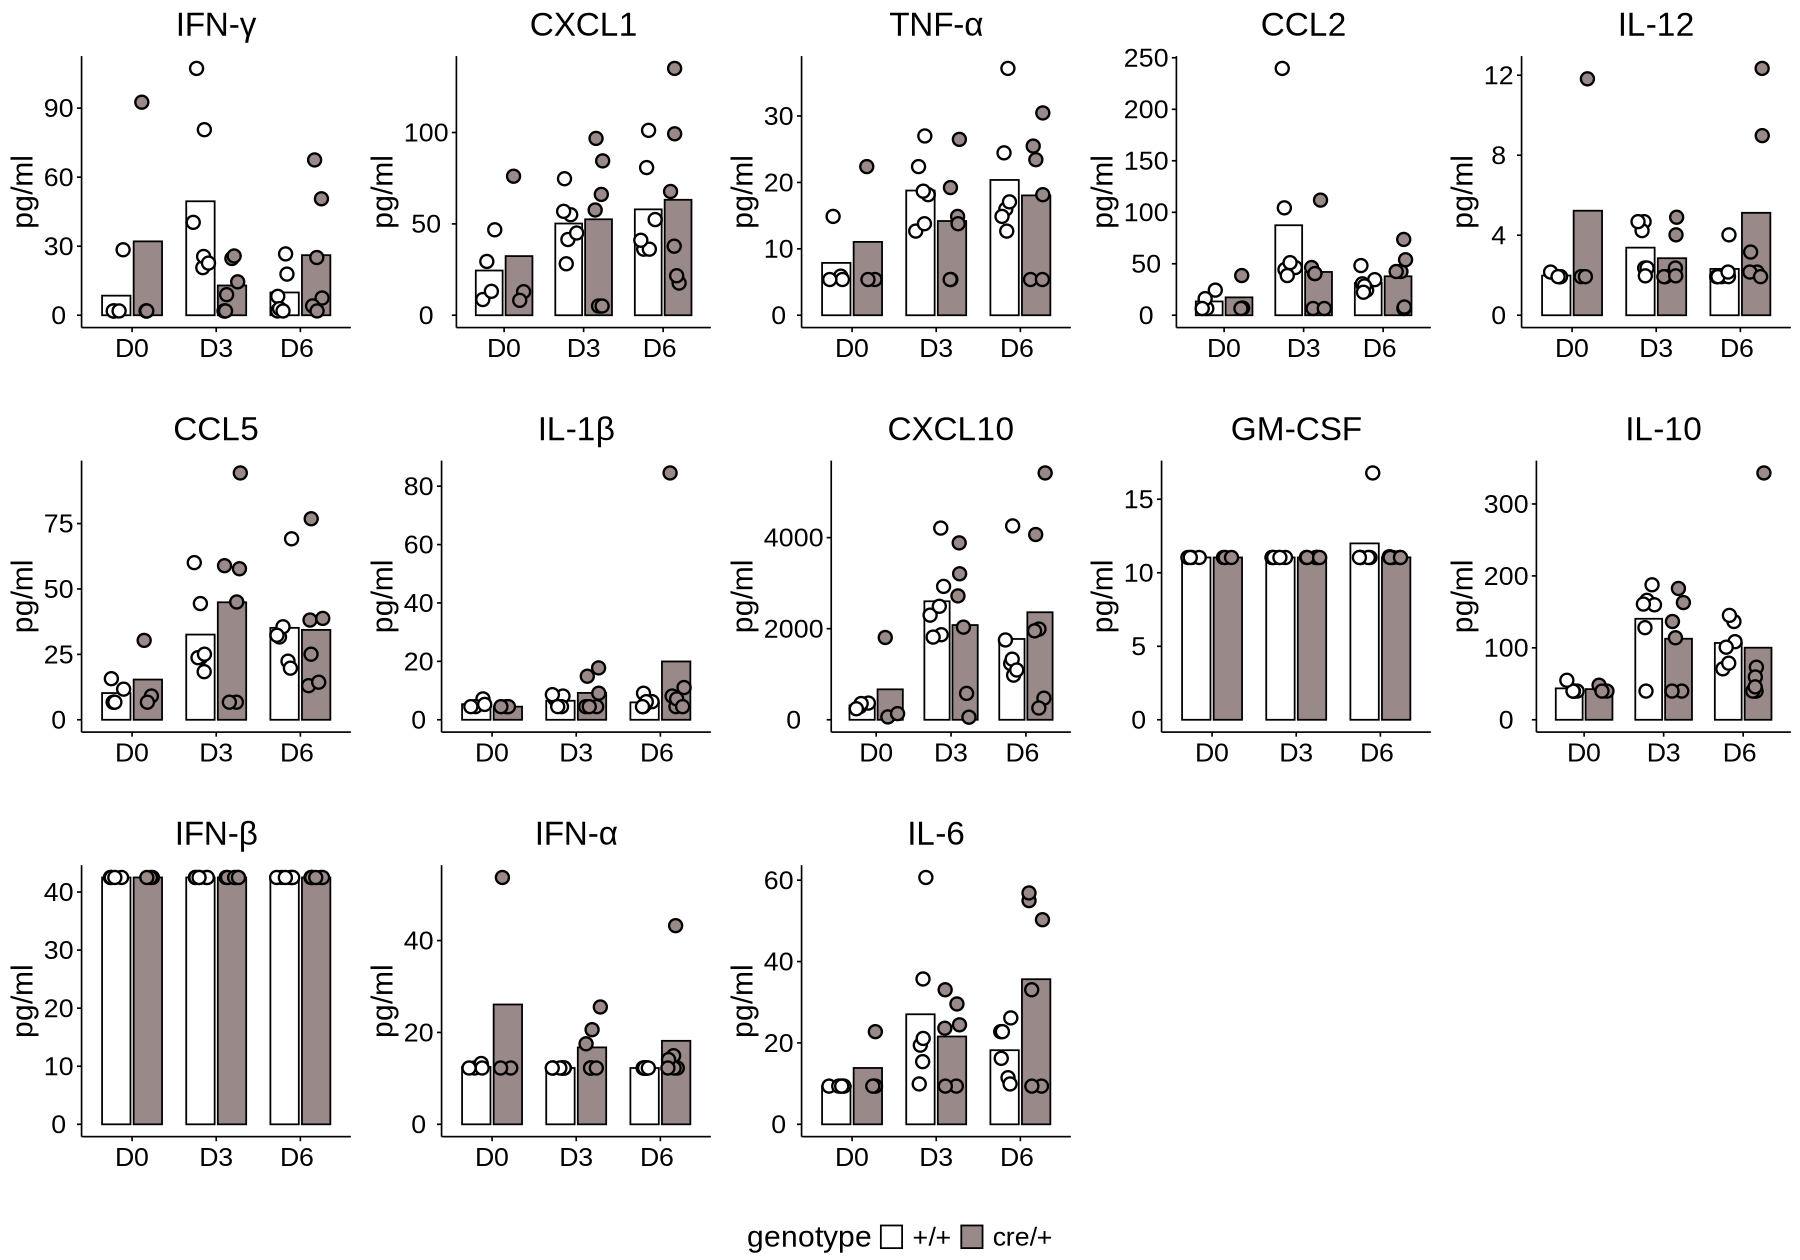

In [118]:
options(repr.plot.width=5*3, repr.plot.height=3*3.5)

ggpubr::ggarrange(plotlist=bar_plot_1, ncol=5, nrow=3, common.legend=TRUE, legend="bottom")

# Spleen 

## Log2FC heatmap 

In [119]:
mat <- read.csv("data/RG374_ifnar_fl_lysmcre_cpg/legendplex/spleen/RG374_ifnar_fl_lysmcre_cpg_spleen_legendplex_data_2024_08_23.csv") %>% 
    dplyr::select(-Mutation.1, -Grad.1, -Mutation.2, -sample) %>% 
    dplyr::rename(genotype=Grad.2, time_point=well) %>% 
    rename_with(~gsub(".", "-", ., fixed=TRUE)) %>% 
    reshape2::melt(., id.vars=c("genotype", "time_point"), variable="cytokine", value.name=c("concentration")) %>% 
    dplyr::group_by(genotype, time_point, cytokine) %>% dplyr::summarise(mean=mean(concentration)) %>% dplyr::ungroup() %>% 
    reshape2::dcast(., time_point + cytokine ~ genotype, value.var="mean") %>% 
    dplyr::mutate(log2fc= log2(`+/+`/`cre/+`)) %>% 
    dplyr::select(time_point, cytokine, log2fc) %>% 
    reshape2::dcast(., time_point ~ cytokine, value.var="log2fc") %>% 
    dplyr::mutate(time_point=ifelse(time_point=="baseline", "D0", gsub("day", "D", time_point))) %>% 
    tibble::column_to_rownames("time_point") %>% as.matrix()

`summarise()` has grouped output by 'genotype', 'time_point'. You can override
using the `.groups` argument.


In [120]:
# Color function - DEG count
color_ramp_mat <- c(color$sample_group["IFNAR_fl_CpG_D1"], "#ffffff", color$sample_group["IFNAR_fl_LysM_cre_CpG_D1"])
breaks_mat <- seq(-round(max(abs(mat))), round(max(abs(mat))), length.out=length(color_ramp_mat))
color_function_mat <- circlize::colorRamp2(breaks_mat, color_ramp_mat) 

In [121]:
hm <- ComplexHeatmap::Heatmap(
    
    matrix=mat,

    col=color_function_mat, 
    na_col="white", 

    width=unit(10*ncol(mat), "mm"), 
    height=unit(10*nrow(mat), "mm"), 

    row_title=NULL, 
    row_title_gp=gpar(fontsize=16, fontface="bold"), 

    column_title="Cytokine log2FC pg/ml (Spleen)", 
    column_title_gp=gpar(fontsize=16, fontface="bold"), 

    row_names_gp=gpar(fontsize=16, fontface="italic"), 
    column_names_gp=gpar(fontsize=16, fontface="plain"), 

    cluster_rows=FALSE, 
    show_row_dend=FALSE,
    # row_split=genes$regulation, 
    row_gap=unit(2, "mm"), 
    show_row_names=TRUE, 
    row_names_side="left", 

    cluster_columns=FALSE, 
    cluster_column_slices=FALSE, 
    show_column_dend=FALSE, 
    column_split=NULL, 
    column_gap=unit(1, "mm"), 
    show_column_names=TRUE, 

    top_annotation=NULL, 
    left_annotation=NULL, 

    rect_gp=gpar(col=NA, lwd=0, alpha=1), 

    heatmap_legend_param=list(title="log2FC", title_gp=gpar(fontsize=16, fontface="plain"), labels_gp=gpar(fontsize=16), grid_width=unit(2.5, "mm"), legend_width=unit(2.5, "mm"), grid_height=unit(10, "mm"), legend_height=unit(10, "mm"), at=breaks_mat), 

    border=TRUE, 
    border_gp=gpar(col="black", lwd=unit(0.2, "mm")), 

    use_raster=FALSE, raster_by_magick=FALSE


)

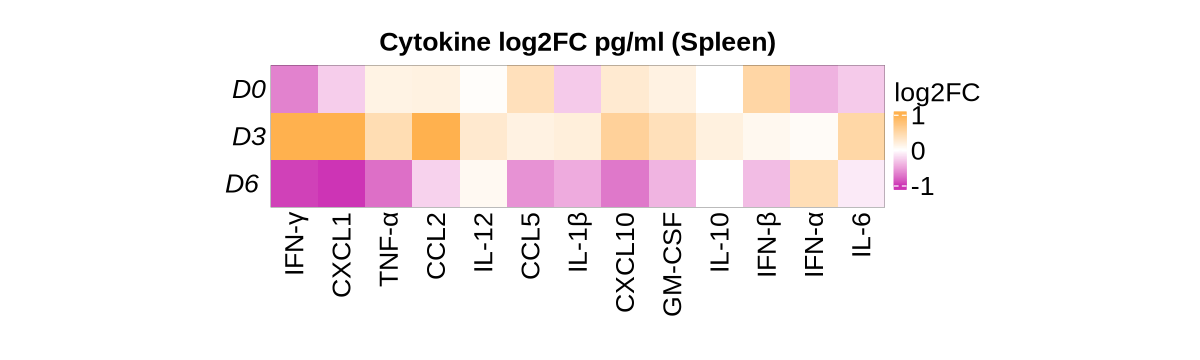

In [122]:
options(repr.plot.width=10, repr.plot.height=3)

hm

## Bar plot 

In [123]:
mat <- read.csv("data/RG374_ifnar_fl_lysmcre_cpg/legendplex/spleen/RG374_ifnar_fl_lysmcre_cpg_spleen_legendplex_data_2024_08_23.csv") %>% 
    dplyr::select(-Mutation.1, -Grad.1, -Mutation.2, -sample) %>% 
    dplyr::rename(genotype=Grad.2, time_point=well) %>% 
    rename_with(~gsub(".", "-", ., fixed=TRUE)) %>% 
    reshape2::melt(., id.vars=c("genotype", "time_point"), variable="cytokine", value.name=c("concentration")) %>% 
    dplyr::mutate(time_point=ifelse(time_point=="baseline", "D0", gsub("day", "D", time_point))) %>% 
    dplyr::mutate(genotype=factor(genotype, levels=c("+/+", "cre/+"))) 

In [124]:
bar_plot <- function(mat) {
    
    ggplot(mat, aes(x=time_point, y=concentration, color=genotype, fill=genotype)) + 
    
        geom_bar(stat="summary", position=position_dodge2(), width=0.75, fun=mean, color="black") + 
        geom_jitter(position=position_jitterdodge(dodge.width=0.75), shape=21, stroke=1.0, size=3, show.legend=FALSE, color="black") + 
        xlab("") + ylab("pg/ml") + ggtitle(mat$cytokine[1]) + 
        scale_color_manual(values=color$genotype) + 
        scale_fill_manual(values=color$genotype) 
    
}

bar_plot_1 <- lapply(split(mat, f=mat$cytokine), bar_plot)

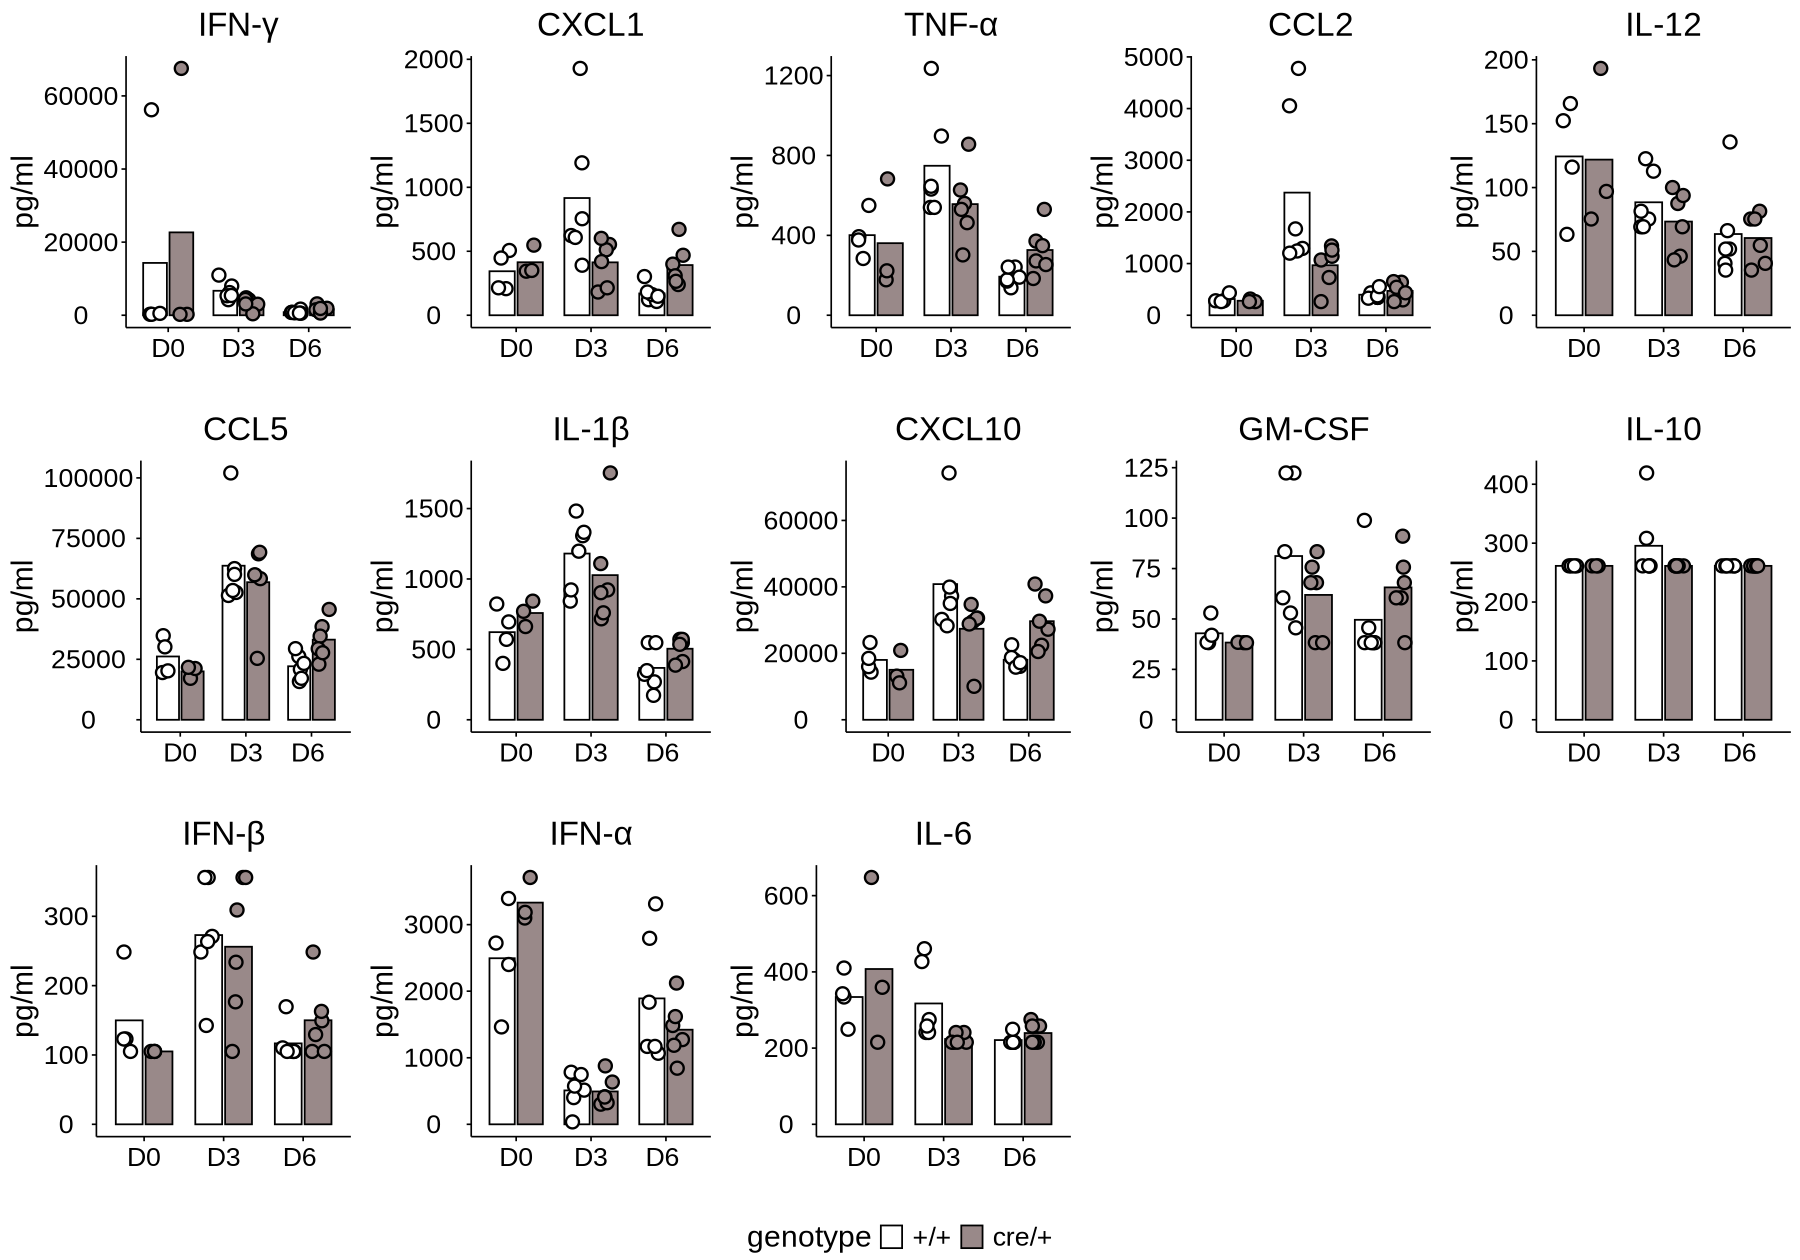

In [125]:
options(repr.plot.width=5*3, repr.plot.height=3*3.5)

ggpubr::ggarrange(plotlist=bar_plot_1, ncol=5, nrow=3, common.legend=TRUE, legend="bottom")